# Tutorial 2: Model training


In this tutorial, we will train a CoxPH model using a ElasticSearch backend.

## Demo Preparation

We will simulate a local ES index for this example. The dataset used is [User Churn dataset](https://square.github.io/pysurvival/tutorials/churn.html).

In [1]:
!pip install pysurvival &> /dev/null

import numpy as np
import eland as ed
from pysurvival.datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

# Load dataset
raw_dataset = Dataset('churn').load() 

time_column = 'months_active'
event_column = 'churned'

features = np.setdiff1d(raw_dataset.columns, [time_column, event_column] ).tolist()

# Upload dataframe to ES 
ed.pandas_to_eland(raw_dataset,
                   es_client='localhost',
                   es_dest_index='churn-prediction',
                   es_if_exists='replace',
                   es_dropna=True,
                   es_refresh=True,
                  ) 

,articles_viewed,churned,company_size,csat_score,marketing_emails_clicked,minutes_customer_support,months_active,product_accounting,product_data_storage,product_payroll,product_travel_expense,smartphone_notifications_viewed,social_media_ads_viewed,us_region
0,4,1.0,10-50,9,14,8.3,3.0,No,2048,Active,Free-Trial,0,1,West North Central
1,4,1.0,100-250,9,12,0.0,2.0,Active,2048,Free-Trial,Free-Trial,2,1,South Atlantic
2,3,0.0,100-250,9,17,0.0,7.0,Active,2048,Active,Active,2,1,East South Central
3,0,1.0,50-100,10,14,0.0,8.0,No,500,Free-Trial,Active,0,0,East South Central
4,5,0.0,50-100,8,17,0.0,7.0,Free-Trial,5120,Active,Free-Trial,0,0,East North Central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,0.0,50-100,9,19,0.4,8.0,Free-Trial,1024,Active,Free-Trial,0,1,Mountain
1996,3,1.0,50-100,7,15,0.0,2.0,Active,1024,Active,Free-Trial,0,0,Middle Atlantic
1997,5,1.0,10-50,8,15,5.9,1.0,Active,500,Active,Free-Trial,0,0,West North Central
1998,6,1.0,100-250,10,15,3.3,3.0,Active,500,No,Free-Trial,1,1,Pacific


## Data Backend



In [2]:
from elastic_surv.dataset import ESDataset

dataset = ESDataset(
    es_index_pattern = 'churn-prediction',
    time_column = 'months_active',
    event_column = 'churned',
    es_client = "localhost",
)

## Train a survival model on the ES backend

0:	[1s / 1s],		train_loss: 4.2061,	val_loss: 4.0502
1:	[1s / 2s],		train_loss: 4.1108,	val_loss: 4.0186
2:	[1s / 4s],		train_loss: 4.0604,	val_loss: 4.0850
3:	[1s / 5s],		train_loss: 4.0563,	val_loss: 4.1450
4:	[1s / 6s],		train_loss: 4.0498,	val_loss: 4.0889
5:	[1s / 8s],		train_loss: 4.0334,	val_loss: 4.0447
6:	[1s / 9s],		train_loss: 4.0625,	val_loss: 4.0248
7:	[1s / 10s],		train_loss: 4.0481,	val_loss: 4.0098
8:	[1s / 12s],		train_loss: 4.0200,	val_loss: 4.0081
9:	[1s / 13s],		train_loss: 4.0057,	val_loss: 4.0022
10:	[1s / 14s],		train_loss: 3.9790,	val_loss: 3.9839
11:	[1s / 16s],		train_loss: 3.9846,	val_loss: 3.9742
12:	[1s / 17s],		train_loss: 3.9870,	val_loss: 3.9805
13:	[1s / 19s],		train_loss: 3.9296,	val_loss: 3.9195
14:	[1s / 20s],		train_loss: 3.9017,	val_loss: 3.9217
15:	[1s / 21s],		train_loss: 3.8933,	val_loss: 3.9099
16:	[1s / 23s],		train_loss: 3.8647,	val_loss: 3.8759
17:	[1s / 24s],		train_loss: 3.8164,	val_loss: 3.7650
18:	[1s / 25s],		train_loss: 3.7667,	val_loss

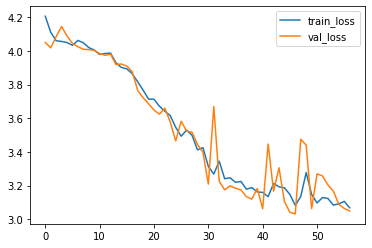

In [3]:
from elastic_surv.models import CoxPHModel

model = CoxPHModel(
    in_features = dataset.features(),
    verbose = True
)
model.train(dataset)

In [4]:
model.score(dataset)

{'c_index': 0.8142792296219441, 'brier_score': 0.07785579105365145}

## Prediction

We can evaluate the survival function for new data.

The output of the `predict` call is a `[time_horizons x number_of_testcases]` matrix.

For each row and for each time horizon, the matrix contains the probability of "survival" at that timestamp for that subject.
The 'survival' is defined by the dataset outcome - user churn, in our example.


In [11]:
import torch

test_ds = dataset.copy().test()
test_dl = test_ds.dataloader(batch_size=len(test_ds))
x_test, y_test = next(iter(test_dl))
 

prediction = model.predict(x_test)

prediction

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
duration,,,,,,,,,,,,,,,,,,,,,
2.0,0.999130,0.989742,0.993426,0.986417,0.745592,0.906564,0.742448,0.837337,0.927993,0.971719,...,0.993151,0.818530,0.822959,0.999691,0.773948,0.994327,0.832548,0.829009,0.809558,0.821469
3.0,0.996852,0.963349,0.976396,0.951679,0.345366,0.701010,0.340120,0.525767,0.762899,0.901322,...,0.975419,0.484245,0.493802,0.998882,0.395351,0.979610,0.514957,0.507075,0.465298,0.490572
4.0,0.996852,0.963349,0.976396,0.951679,0.345366,0.701010,0.340120,0.525767,0.762899,0.901322,...,0.975419,0.484245,0.493802,0.998882,0.395351,0.979610,0.514957,0.507075,0.465298,0.490572
5.0,0.996852,0.963349,0.976396,0.951679,0.345366,0.701010,0.340120,0.525767,0.762899,0.901322,...,0.975419,0.484245,0.493802,0.998882,0.395351,0.979610,0.514957,0.507075,0.465298,0.490572
7.0,0.967650,0.677455,0.779492,0.596594,0.000015,0.024608,0.000013,0.001225,0.059466,0.338417,...,0.771392,0.000520,0.000637,0.988405,0.000063,0.806669,0.000987,0.000840,0.000343,0.000595


## Plot the average survival probability for the test population

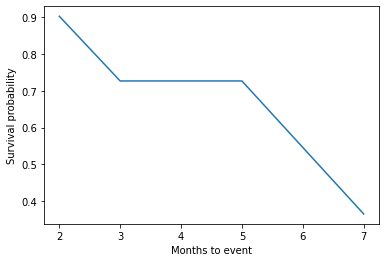

In [21]:
!pip install seaborn &> /dev/null

import seaborn as sns
import matplotlib.pyplot as plt

avg_surv = np.mean(prediction, axis = 1)

ax = sns.lineplot(data=avg_surv)
ax.set(xlabel='Months to event', ylabel='Survival probability')

plt.show()